# 0 Running the code
This code can be run by clicking 'Run all Cells'.
The program will require a file called latestdata.csv containing the dataset given for the coursework.
The program will create 2 further csv files, one contains the subset of the dataset that is relevant for classification task and the other contains the encoded version of that dataset.

# 1 Import Dataset
The first step is to import the dataset and have a look at which columns contain a lot of data points

Please note that the program expects the dataset to be saved as latestdata.csv in the same folder as the program.

In [1]:
import pandas as pd
import numpy as np

# Read in the dataset
try:
    cov = pd.read_csv("latestdata.csv")
    print('Read dataset from latestdata.csv')
    # Inspect data
    print(cov.count())
except Exception as e:
    print('Dataset not available ', e)



/home/sam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
Read dataset from latestdata.csv
ID                          2676311
age                          578018
sex                          580157
city                        1698630
province                    2223647
country                     2676196
latitude                    2676250
longitude                   2676250
geo_resolution              2676250
date_onset_symptoms          261599
date_admission_hospital      116211
date_confirmation           2567822
symptoms                       2052
lives_in_Wuhan                 4338
travel_history_dates           2611
travel_history_location        9222
reported_market_exposure       1069
additional_information        45855
chronic_disea

# 2 Data Preparation

## 2.1 Drop irrelevant columns and rows

In [2]:
# Identify the columns required for the problem
fields = ["outcome", "age", "sex", "date_confirmation", "date_onset_symptoms", "country"] # 3493 rows - mostly from the phillipines
dataset = cov[fields]
 
# Drop the rows which are missing information
dataset = dataset.dropna(subset=fields)

# Store the set for future use
dataset.to_csv("dataset.csv")
print('Stored dataset as dataset.csv')

Stored dataset as dataset.csv


In [3]:
# Instead of doing the above steps you can load the processed dataset
import pandas as pd
dataset = pd.read_csv('dataset.csv')
print('Read dataset from dataset.csv')
# Drop the unnamed column
dataset = dataset.drop(columns=['Unnamed: 0'])

print(dataset.count())

Read dataset from dataset.csv
outcome                3493
age                    3493
sex                    3493
date_confirmation      3493
date_onset_symptoms    3493
country                3493
dtype: int64


## 2.2 Feature encoding

In [4]:
# Tidy the outcome column
dataset = dataset.replace(to_replace={'outcome': {
    'died':0,
    'death':0,
    'Deceased':0,
    'dead':0,
    'stable':1,
    'treated in an intensive care unit (14.02.2020)':1,
    'Symptoms only improved with cough. Currently hospitalized for follow-up.':1, # TODO drop and compare results
    'severe':0,        
    'Hospitalized':1, # TODO drop and compare results
    'discharge':1,
    'discharged':1,
    'Discharged':1,
    'Alive':1,
    'recovered':1,
    }})

# Tidy the ages column
dataset = dataset.replace(to_replace={'age': {
    '0-9':5,
    '10-19':15,
    '20-29':25,
    '30-39':35,
    '40-49':45,
    '50-59':55,
    '60-69':65,
    '70-79':75,
    '80-89':85,
    '90-99':95,
    }}, regex=True)

# Apply feature scaling to the ages
from sklearn.preprocessing import MinMaxScaler
age_scaler = MinMaxScaler()
dataset[['age']] = age_scaler.fit_transform(dataset[['age']])

# Replace the two dates columns with days_waiting
gaps = []
from datetime import date, datetime, timedelta
for i in range(len(dataset['date_confirmation'])):
    dataset['date_confirmation'][i] = datetime.strptime(dataset['date_confirmation'][i], r'%d.%m.%Y')
    dataset['date_onset_symptoms'][i] = datetime.strptime(dataset['date_onset_symptoms'][i], r'%d.%m.%Y')
    gaps.append(dataset['date_confirmation'][i] - dataset['date_onset_symptoms'][i])

dataset['days_waiting'] = gaps
dataset = dataset.drop(columns=['date_confirmation', 'date_onset_symptoms'])
dataset['days_waiting'] = dataset['days_waiting'].dt.days
dataset = dataset[dataset['days_waiting'] >= 0]
dw_scaler = MinMaxScaler()
dataset[['days_waiting']] = dw_scaler.fit_transform(dataset[['days_waiting']])

# Encode the sex data as integers
dataset = dataset.replace(to_replace={'sex': {
    'male':0,
    'female':1
}})

# Encode the country data using one hot encoding
countries_df = pd.get_dummies(dataset['country'])
dataset = pd.concat([dataset, countries_df], axis=1)
dataset = dataset.drop(columns=['country'])

print(dataset.head)

# Save the cleaned up dataset for future use
dataset.to_csv('dataset_clean.csv')
print('Saved dataset as dataset_clean.csv')

/home/sam/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<bound method NDFrame.head of       outcome       age  sex  days_waiting  Angola  Brazil  Cabo Verde  \
0           1  0.797980    1      0.180723       0       0           0   
1      

# 3 Visualisation

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualise(variable):
    fig, ax = plt.subplots(1,3, figsize=(20,5))

    data = dataset[variable]
    sns.histplot(data=data, ax=ax[0])

    data = dataset.loc[dataset['outcome'] == 0, variable]
    sns.histplot(data=data, ax=ax[1]).set_title('Died')
    data = dataset.loc[dataset['outcome'] == 1, variable]
    sns.histplot(data=data, ax=ax[2]).set_title('Recovered')

    # print(f'Produced graphs to show the distribution of the encoded {variable} for the dataset, those that died and those that recovered')

visualise('age')
visualise('days_waiting')

In [6]:
def pie_chart(sizes, labels):
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()

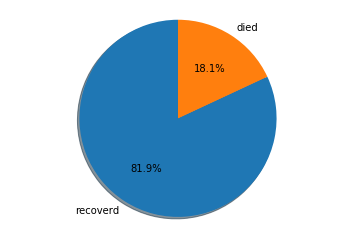

In [7]:
values = dataset['outcome'].value_counts()
labels = 'recoverd', 'died'

pie_chart(values, labels)

Percentage of total dataset by gender


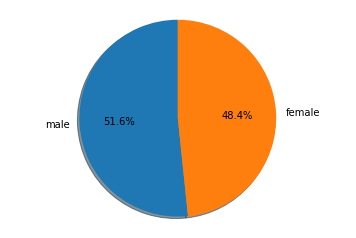

Percentage of individuals who died by gender


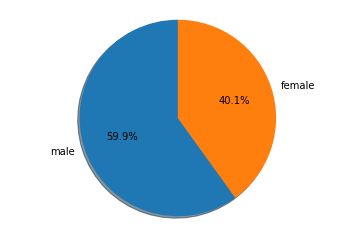

Percentage of individuals who recovered by gender


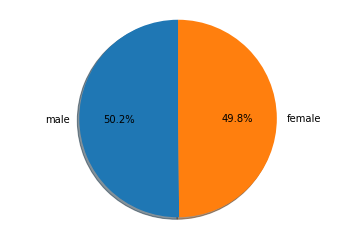

In [8]:
values = dataset['sex'].value_counts()
labels = 'male', 'female'

print('Percentage of total dataset by gender')
pie_chart(values, labels)

print('Percentage of individuals who died by gender')
values = dataset.loc[dataset['outcome'] == 0, 'sex'].value_counts()
pie_chart(values, labels)

print('Percentage of individuals who recovered by gender')
values = dataset.loc[dataset['outcome'] == 1, 'sex'].value_counts()
pie_chart(values, labels)


## 4.1 Split the dataset into features/labels and test/train

In [9]:
# Split the data into features and labels
features = dataset.drop(['outcome'], axis=1)
labels = dataset['outcome']

# print('features\n', features.value_counts())
# print('labels\n', labels.value_counts())

# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=0) # This also shuffles the data

## 4.2 Fit the models
In this section we fit 6 different models for comparison. From this 6 I will choose the best performing 3.

In [10]:
# Import and fit a Support Vector Machine
from sklearn import svm
svm_classifier = svm.SVC(gamma='auto', class_weight={0: 2832/624, 1:1})
svm_classifier.fit(X_train, y_train)

# Immport and fit a logistic regression model
from sklearn import linear_model
# LR_classifier = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000) # MULTINOMIAL There are five solvers that can be used to obtain the weights 
LR_classifier = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000, class_weight={0: 2832/624, 1:1})
LR_classifier.fit(X_train, y_train)

# Import and fit a decision tree
from sklearn import tree
tree_classifier = tree.DecisionTreeClassifier(class_weight={0: 2832/624, 1:1})
tree_classifier.fit(X_train, y_train)

# Import a random forest
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier(class_weight={0: 2832/624, 1:1}, n_estimators=100)
forest_classifier.fit(X_train, y_train)

# Import and fit a naive bayes model
from sklearn.naive_bayes import GaussianNB
# nb_classifier = GaussianNB(priors=[624/3456, 2832/3456])
nb_classifier = GaussianNB(priors=[2832/3456, 624/3456])
nb_classifier.fit(X_train, y_train)

# Import and fit a k nearest neighbours model
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

print('Trained a selection of models on the training data')

Trained a selection of models on the training data


# 5 Model Evaluation

In this section we look at how the models performed on the test set. 
This allows us to select the top 3 models before attempting to improve their performance through hyperparameter tuning.

The evaluation metrics of interest at this step are the accuracy, balanced_accuracy and f1_score

## 5.1 Use the models to make some predictions

In [11]:
# Make predictions on the test dataset with each model
svm_predictions = svm_classifier.predict(X_test)
LR_predictions = LR_classifier.predict(X_test)
tree_predictions = tree_classifier.predict(X_test)
forest_predictions = forest_classifier.predict(X_test)
nb_predictions = nb_classifier.predict(X_test)
knn_predictions = knn_classifier.predict(X_test)

## 5.2 Measure the accuracy of the predictions

The accuracy is immediately easy to interpret and is therefore worth examining before looking at other metrics

In [12]:
# Measure the accuracy of each set of predictions
from sklearn import metrics
svm_accuracy = metrics.accuracy_score(y_test, svm_predictions)
LR_accuracy = metrics.accuracy_score(y_test, LR_predictions)
tree_accuracy = metrics.accuracy_score(y_test, tree_predictions)
forest_accuracy = metrics.accuracy_score(y_test, forest_predictions)
nb_accuracy = metrics.accuracy_score(y_test, nb_predictions)
knn_accuracy = metrics.accuracy_score(y_test, knn_predictions)

print(f'SVM accuracy: {svm_accuracy}\nLR accuracy: {LR_accuracy}\nTree accuracy: {tree_accuracy}\nForest accuracy: {forest_accuracy}\nNaive Bayes accuracy: {nb_accuracy}\nkNN accuracy: {knn_accuracy}')

SVM accuracy: 0.7052023121387283
LR accuracy: 0.7225433526011561
Tree accuracy: 0.7254335260115607
Forest accuracy: 0.7630057803468208
Naive Bayes accuracy: 0.2543352601156069
kNN accuracy: 0.815028901734104


## 5.3 View more detailed evaluations
This function returns the accuracy, balanced accuracy and f1 scores for the models.
It also shows the confusion matrix and an analysis of the precision and recall.

In [13]:
def custom_score(y_test, predictions):
    accuracy = metrics.accuracy_score(y_test, predictions)
    balanced_accuracy = metrics.balanced_accuracy_score(y_test, predictions)
    f1score = metrics.f1_score(y_test, predictions)
    custom_score = round((3*accuracy + 3*balanced_accuracy + 1*f1score)/7, 4)
    return custom_score

In [14]:
def custom_scorer(model, X_test, y_test):
    predictions = model.predict(X_test)
    return custom_score(y_test, predictions)

In [15]:
def evaluate(model_name, predictions):
    print('\033[95m' + model_name.upper() + '\033[0m')
    scores = pd.DataFrame()
    accuracy = metrics.accuracy_score(y_test, predictions)
    balanced_accuracy = metrics.balanced_accuracy_score(y_test, predictions)
    f1score = metrics.f1_score(y_test, predictions)
    scores[model_name] = [accuracy, balanced_accuracy, f1score]
    scores.index = ['Accuracy', 'Balanced Accuracy', 'f1 Score']
    print(scores)
    print(f'\nCustom score {custom_score(y_test, predictions)}')
    print(f'\nConfusion matrix for {model_name}:')
    print(metrics.confusion_matrix(y_test, predictions))
    print(f'\nFull classification report for {model_name}:')
    print(metrics.classification_report(y_test, predictions, target_names=['died','recovered']))
    print('\n')
    return (custom_score(y_test, predictions), model_name)

nb_score = evaluate('Naive Bayes', nb_predictions)
tree_score = evaluate('Decision tree', tree_predictions)
svm_score = evaluate('SVM', svm_predictions)
knn_score = evaluate('K Nearest Neighbours', knn_predictions)
lr_score = evaluate('Logistic Regression', LR_predictions)
forest_score = evaluate('Random forest', forest_predictions)

NAIVE BAYES
                   Naive Bayes
Accuracy              0.254335
Balanced Accuracy     0.532609
f1 Score              0.122449

Custom score 0.3548

Confusion matrix for Naive Bayes:
[[ 70   0]
 [258  18]]

Full classification report for Naive Bayes:
              precision    recall  f1-score   support

        died       0.21      1.00      0.35        70
   recovered       1.00      0.07      0.12       276

   micro avg       0.25      0.25      0.25       346
   macro avg       0.61      0.53      0.24       346
weighted avg       0.84      0.25      0.17       346



DECISION TREE
                   Decision tree
Accuracy                0.725434
Balanced Accuracy       0.662629
f1 Score                0.816956

Custom score 0.7116

Confusion matrix for Decision tree:
[[ 39  31]
 [ 64 212]]

Full classification report for Decision tree:
              precision    recall  f1-score   support

        died       0.38      0.56      0.45        70
   recovered       0.87     

## 5.4 Rank the models

In [16]:
print('Ranking the models according to the custom score\n')
ranks = [nb_score, tree_score, svm_score, knn_score, lr_score, forest_score]
ranks.sort()
for rank in ranks:
    print(rank)

Ranking the models according to the custom score

(0.3548, 'Naive Bayes')
(0.7116, 'Decision tree')
(0.7255, 'SVM')
(0.7309, 'Random forest')
(0.7376, 'Logistic Regression')
(0.7479, 'K Nearest Neighbours')


At this point we can see that the top performing models are the Logistic Regression model, the K-Nearest Neighbours model and the Random Forest model. These are the models I use from this point onwards.

# 6 Model Improvement

This section involves trying a cross validation method and hyperparameter tuning to try and improve the models
The tuning actually occurs during the .fit() call on the GridSearchCV object.
Calling this on the training data means cross validation folds are automatically generated from the training data and the test data remains unseen (to be used for evaluation later).
Because of this, we can see that the accuracy of the models is lower than the previous accuracy but we hope that the model quality has improved regardless. This will be tested at the end.

For each model, we want to find the best set of parameters to improve the accuracy.


In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

objectives = ['accuracy', 'balanced_accuracy']

## 6.1 Tune the hyperparameters for Logistic Regression
We will tune the solvers, C value and max_iterations parameters.

In [18]:
# Tune logistic regression hyperparameters
model = linear_model.LogisticRegression()

class_weight = [{0: 2832/624, 1:1}]

solvers = ['lbfgs', 'liblinear']
c_values = [100, 10, 1, 0.1, 0.01]
max_iter = [500, 1000]

lr_param_grid = dict(class_weight=class_weight, solver=solvers, C=c_values, max_iter=max_iter)

lr_search = GridSearchCV(estimator=model, param_grid=lr_param_grid, n_jobs=-1, cv=5, scoring=custom_scorer, error_score=0, verbose=0)
# lr_search = RandomizedSearchCV(estimator=model, param_distributions=lr_param_grid, n_jobs=-1, cv=5, scoring=custom_scorer, error_score=0, verbose=0)

lr_final_classifier = lr_search.fit(X_train, y_train)
print(f"The best score was: {lr_final_classifier.best_score_} using {lr_final_classifier.best_params_}")

The best score was: 0.7569926366559485 using {'C': 1, 'class_weight': {0: 4.538461538461538, 1: 1}, 'max_iter': 500, 'solver': 'lbfgs'}


## 6.2 Tune the hyperparameters for K-Nearest Neighbours
We will tune the number of neighbours searched, the algorithm for computing nearest neighbours and the weights

In [19]:
# Tune kNN parameters
model = KNeighborsClassifier()

# class_weight = [{0: 2832/624, 1:1}]

n_neighbors = [2,3,4,5,6,7,8,9,10]
weights = ['uniform', 'distance']
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

knn_param_grid = dict(n_neighbors=n_neighbors, weights=weights, algorithm=algorithms)

knn_search = GridSearchCV(estimator=model, param_grid=knn_param_grid, n_jobs=-1, cv=5, scoring=custom_scorer, error_score=0, verbose=0)
# knn_search = RandomizedSearchCV(estimator=model, param_distributions=knn_param_grid, n_jobs=-1, cv=5, scoring=custom_scorer, error_score=0, verbose=0)

knn_final_classifier = knn_search.fit(X_train, y_train)
print(f"The best score was: {knn_final_classifier.best_score_} using {knn_final_classifier.best_params_}")

The best score was: 0.7325461414790997 using {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'uniform'}


## 6.3 Tune the random forest hyperparameters
We will tune the number of estimators, the criterion for selection, the maximum tree depth and the maximum number of features.

In [20]:
# Tune random forest hyperparameters
model = RandomForestClassifier()

class_weight = [{0: 2832/624, 1:1}]

n_estimators = [10, 50, 100, 200]
criterions = ['gini', 'entropy']
max_depths = [None, 10, 100]
max_features = ['auto', 'sqrt', 'log2']

rf_param_grid = dict(class_weight=class_weight, n_estimators=n_estimators, criterion=criterions, max_depth=max_depths, max_features=max_features)

rf_search = GridSearchCV(estimator=model, param_grid=rf_param_grid, n_jobs=-1, cv=5, scoring=custom_scorer, error_score=0, verbose=0)
# rf_search = RandomizedSearchCV(estimator=model, param_distributions=rf_param_grid, n_jobs=-1, cv=5, scoring=custom_scorer, error_score=0, verbose=0)
rf_final_classifier = rf_search.fit(X_train, y_train)
print(f"The best score was: {rf_final_classifier.best_score_} using {rf_final_classifier.best_params_}")

The best score was: 0.7627147588424437 using {'class_weight': {0: 4.538461538461538, 1: 1}, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}


# Final models

Using the best parameters determined by the hyper parameter tuning we can create a final set of classifiers

In [21]:
# final_LR_classifier = linear_model.LogisticRegression(
#     class_weight={0: 2832/624, 1:1},
#     solver='liblinear', 
#     max_iter=1000,
#     C=1
# )

# final_knn_classifier = KNeighborsClassifier(
#     weights='uniform',
#     n_neighbors=9,
#     algorithm='auto'
# )

# final_rf_classifier = RandomForestClassifier(
#     class_weight={0: 2832/624, 1:1},
#     n_estimators=50,
#     max_features='auto',
#     max_depth=100,
#     criterion='gini'
# )

# final_rf_classifier.fit(X_train, y_train)
# final_knn_classifier.fit(X_train, y_train)
# final_LR_classifier.fit(X_train, y_train)
# print('Models trained')

In [25]:
models = [lr_final_classifier, knn_final_classifier, rf_final_classifier]
names = ['Logistic Regression', 'k-Nearest Neighbours', 'Random Forest']
predictions = []
accuracies = []
balanced_accuracies = []
custom_scores = []
for i in range(len(models)):
    predictions.append(models[i].predict(X_test))
    accuracies.append(round(metrics.accuracy_score(y_test, predictions[i]), 4))
    balanced_accuracies.append(round(metrics.balanced_accuracy_score(y_test, predictions[i]), 4))
    custom_scores.append(custom_scorer(models[i], X_test, y_test))

print('Accuracy scores for the final models:')
for i in range(len(models)):
    print(accuracies[i], names[i])

print('\nBalanced accuracy scores for the final models:')
for i in range(len(models)):
    print(balanced_accuracies[i], names[i])

print('\nCustom scores for the final models:')
for i in range(len(models)):
    print(custom_scores[i], names[i])

print(f'\nPercentage Accuracy changes by model:')
print(f'{round(((accuracies[0]-LR_accuracy)/LR_accuracy)*100, 4)}% {names[0]}')
print(f'{round(((accuracies[1]-knn_accuracy)/knn_accuracy)*100, 4)}% {names[1]}')
print(f'{round(((accuracies[2]-forest_accuracy)/forest_accuracy)*100, 4)}% {names[2]}')

print(f'\nPercentage Balanced Accuracy changes by model:')
lr_balanced_accuracy = metrics.balanced_accuracy_score(y_test, LR_predictions)
print(f'{round(((balanced_accuracies[0]-lr_balanced_accuracy)/lr_balanced_accuracy)*100, 4)}% {names[0]}')
knn_balanced_accuracy = metrics.balanced_accuracy_score(y_test, knn_predictions)
print(f'{round(((balanced_accuracies[1]-knn_balanced_accuracy)/knn_balanced_accuracy)*100, 4)}% {names[1]}')
forest_balanced_accuracy = metrics.balanced_accuracy_score(y_test, forest_predictions)
print(f'{round(((balanced_accuracies[2]-forest_balanced_accuracy)/forest_balanced_accuracy)*100, 4)}% {names[2]}')

print(f'\nPercentage f1 score changes by model:')
lr_f1_score = metrics.f1_score(y_test, LR_predictions)
print(f'{round(((balanced_accuracies[0]-lr_f1_score)/lr_f1_score)*100, 4)}% {names[0]}')
knn_f1_score = metrics.f1_score(y_test, knn_predictions)
print(f'{round(((balanced_accuracies[1]-knn_f1_score)/knn_f1_score)*100, 4)}% {names[1]}')
forest_f1_score = metrics.f1_score(y_test, forest_predictions)
print(f'{round(((balanced_accuracies[2]-forest_f1_score)/forest_f1_score)*100, 4)}% {names[2]}')

print('\nPercentage changes in the custom score by model:')
print(f'{round( ((custom_scores[0] - custom_scorer(LR_classifier, X_test, y_test)) / custom_scorer(LR_classifier, X_test, y_test) ) * 100, 4)}% {names[0]}')
print(f'{round( ((custom_scores[1] - custom_scorer(knn_classifier, X_test, y_test)) / custom_scorer(knn_classifier, X_test, y_test) ) * 100, 4)}% {names[1]}')
print(f'{round( ((custom_scores[2] - custom_scorer(forest_classifier, X_test, y_test)) / custom_scorer(forest_classifier, X_test, y_test) ) * 100, 4)}% {names[2]}')

Accuracy scores for the final models:
0.7225 Logistic Regression
0.7861 k-Nearest Neighbours
0.7543 Random Forest

Balanced accuracy scores for the final models:
0.7301 Logistic Regression
0.6314 k-Nearest Neighbours
0.7447 Random Forest

Custom scores for the final models:
0.7376 Logistic Regression
0.7317 k-Nearest Neighbours
0.7613 Random Forest

Percentage Accuracy changes by model:
-0.006% Logistic Regression
-3.5494% k-Nearest Neighbours
-1.141% Random Forest

Percentage Balanced Accuracy changes by model:
-0.0033% Logistic Regression
-0.3297% k-Nearest Neighbours
12.9148% Random Forest

Percentage f1 score changes by model:
-9.2906% Logistic Regression
-29.0589% k-Nearest Neighbours
-12.2549% Random Forest

Percentage changes in the custom score by model:
0.0% Logistic Regression
-2.1661% k-Nearest Neighbours
4.1593% Random Forest


In [23]:
for i in range(len(models)):
    evaluate(names[i], predictions[i])

LOGISTIC REGRESSION
                   Logistic Regression
Accuracy                      0.722543
Balanced Accuracy             0.730124
f1 Score                      0.804878

Custom score 0.7376

Confusion matrix for Logistic Regression:
[[ 52  18]
 [ 78 198]]

Full classification report for Logistic Regression:
              precision    recall  f1-score   support

        died       0.40      0.74      0.52        70
   recovered       0.92      0.72      0.80       276

   micro avg       0.72      0.72      0.72       346
   macro avg       0.66      0.73      0.66       346
weighted avg       0.81      0.72      0.75       346



K-NEAREST NEIGHBOURS
                   k-Nearest Neighbours
Accuracy                       0.786127
Balanced Accuracy              0.631366
f1 Score                       0.869258

Custom score 0.7317

Confusion matrix for k-Nearest Neighbours:
[[ 26  44]
 [ 30 246]]

Full classification report for k-Nearest Neighbours:
              precision    recal